In [1]:
import gensim 
import pandas as pd
import logging
import math
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
import random

## Preprocessing and feature engineering

In [21]:
songs = pd.read_csv('spotify_dataset.csv', header=None, skiprows=[0], usecols=[0,1,2,3]).dropna()
songs.columns = ['user_id', 'artistname','trackname','playlistname']

In [22]:
display(songs.shape)
display(songs['trackname'].nunique())

(12867139, 4)

2009210

In [23]:
print(songs[songs['artistname'] == 'Pink Floyd'].trackname[0:20].to_string())

896                                         Sorrow - Live
1057                                     Comfortably Numb
1058                              Comfortably Numb - Live
1098                     Echoes - 2011 Remastered Version
1099                    Eclipse - 2011 Remastered Version
1186                                       Hey You - Live
1187                                    High Hopes - Live
1414                    Shine On You Crazy Diamond - Live
1554     Welcome To The Machine - 2011 Remastered Version
1568                 Wish You Were Here - 2011 - Remaster
4193               Brain Damage - 2011 Remastered Version
5123               Echoes - Edit; 2001 Remastered Version
5353                   Fearless - 2011 Remastered Version
7647                      Money - 2011 Remastered Version
10929                                  Wish You Were Here
10930                Wish You Were Here - 2011 - Remaster
11229              Brain Damage - 2011 Remastered Version
12235         

In [24]:
#Every artist can have only one version of the song, reduces unique songs from 2009210 to 1367548

def preprocess_track(trackname):

    trackname = trackname.lower()
    
    
    # everything between [], () is often live remaster etc.
    trackname = re.sub("[\(\[].*?[\)\]]", "", trackname)
    
    #"remove different identifiers only difference of couple of thousand words
    #removed_words = ['radio edit', 'explicit', 'live', 'remaster', 'remastered', 'remix','mix', 'vevo', 'version']
    #for i in removed_words:
    #    trackname = trackname.replace(i, '')
        
    #Remove everything after '-' as they most likely are live, remastered, year etc identifiers
    trackname = trackname.split('-', 1)[0]
    #Remove empty spaces around the trackname
    trackname = trackname.strip()     
       
    return trackname

In [25]:
songs['trackname'] = songs['trackname'].copy().apply(preprocess_track)
#Alternatively only song names to lowercase
#songs['trackname'] = songs['trackname'].map(lambda x: x.lower())
songs['artistname'] = songs['artistname'].map(lambda x: x.lower())

In [26]:
#uniques after preprocessing
songs['trackname'].nunique()

1367548

In [28]:
print(songs[songs['artistname'] == 'pink floyd'].trackname[0:20].to_string())

896                          sorrow
1057               comfortably numb
1058               comfortably numb
1098                         echoes
1099                        eclipse
1186                        hey you
1187                     high hopes
1414     shine on you crazy diamond
1554         welcome to the machine
1568             wish you were here
4193                   brain damage
5123                         echoes
5353                       fearless
7647                          money
10929            wish you were here
10930            wish you were here
11229                  brain damage
12235                         money
12809                         money
28819                one of the few


In [27]:
#Make two new features
#trackartist: identifty the spesific track of the artist to differ between same named songs from different artist (meta2prodvec)
songs["trackartist"] = songs["artistname"] + " - " +songs["trackname"]
#userplaylist to differ between playlists named the same
songs["userplaylist"] = songs["user_id"] + " - " +songs["playlistname"]


In [30]:
songs.head()

,user_id,artistname,trackname,playlistname,trackartist,userplaylist
0,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,red shoes,HARD ROCK 2010,elvis costello - red shoes,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,"peace, love and understanding",HARD ROCK 2010,"elvis costello & the attractions - peace, love...",9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,tiffany page,7 years too late,HARD ROCK 2010,tiffany page - 7 years too late,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,accidents will happen,HARD ROCK 2010,elvis costello & the attractions - accidents w...,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,alison,HARD ROCK 2010,elvis costello - alison,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010


In [29]:
#large increase in unique songs
songs['trackartist'].nunique()

2342855

In [31]:
frequency_of_songs = songs.groupby('trackartist').count()['user_id']

In [32]:
sorted_frequencies = frequency_of_songs.sort_values(ascending=False)

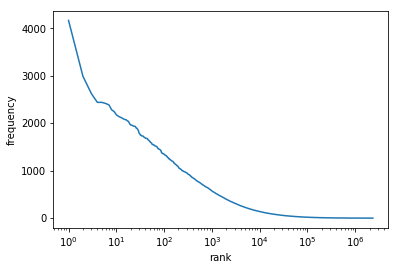

In [33]:
plt.plot(np.arange(1,2342856),sorted_frequencies[0:2342855])
plt.ylabel('frequency')
plt.xlabel('rank')
plt.xscale('log')

plt.show()

In [34]:
#Remove playlist with less than 10 tracks and combine into lists
playlists = songs.groupby(['userplaylist']).filter(lambda x: len(x) >= 10)
playlists = playlists.groupby(['userplaylist']).agg({'trackartist':lambda x: list(x)})

In [ ]:
##playlists[playlists.index.str.match('0007f3dd09c91198371454c608d47f22 - Fav songs')]
display(playlists.head())
display(playlists.shape)

In [36]:
def to_document(playlists):
    documents = []
    for index, row in playlists.iterrows():
        preprocessed_songs = row['trackartist']
        documents.append(preprocessed_songs)

    return documents    

In [37]:
documents = to_document(playlists)
doc_length = len(documents)

### UCI online retail data set

In [2]:
#http://archive.ics.uci.edu/ml/datasets/Online+Retail

In [3]:
retail = pd.read_excel('Online Retail.xlsx')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
retail['Description'].nunique()

4223

In [11]:
retail_grouped = retail.groupby('InvoiceNo')['Description'].apply(list)

In [12]:
len(retail_grouped)

25900

In [13]:
retail_grouped = pd.DataFrame(retail_grouped)
retail_grouped = retail_grouped[retail_grouped['Description'].str.len() >= 10]

In [14]:
len(retail_grouped)

13167

In [15]:
def shopping_basket_format(baskets):
    baskets_formatted = []
    for index, row in baskets.iterrows():
        baskets_formatted.append(row[0])

    return baskets_formatted 

In [16]:
baskets = shopping_basket_format(retail_grouped)
baskets_length = len(baskets)

## Training Word2vec-music recommender

In [10]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
np.random.seed(0)

In [97]:
#Train with 80 % of the data (with cross validation) and test the final model with 20% of the data
#train/test split for spotify playlist
index = np.random.choice(range(doc_length), doc_length, replace=False)
train = np.array(documents)[index[:int(doc_length * 0.8)]].tolist()
test = np.array(documents)[index[int(doc_length * 0.8):]].tolist()

In [17]:
#train/test split for shopping baskets
index = np.random.choice(range(baskets_length), baskets_length, replace=False)
train = np.array(baskets)[index[:int(baskets_length * 0.8)]].tolist()
test = np.array(baskets)[index[int(baskets_length * 0.8):]].tolist()

In [17]:
#Help:
#https://github.com/manasRK/word2vec-recommender/blob/master/semsim_train.py
#https://arxiv.org/abs/1804.04212
#http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
#https://stackoverflow.com/questions/38287772/cbow-v-s-skip-gram-why-invert-context-and-target-words

In [93]:
#initial parameteres from https://arxiv.org/abs/1804.04212
window_size=7
it=90#increasing this leads to returning words with high similarity
sample=0.001 
power_alpha=-0.5

size_embedding=50
neg_sample=5
workers=10
min_count=10

#sg 0 == cbow
#sg1 == skip gram
sg_type=1

model = gensim.models.Word2Vec(train, size=size_embedding, window=window_size,
                 min_count=min_count, workers=workers, sg=1, iter=it,
                 sample=sample, negative=neg_sample, alpha=power_alpha)

model.train(train,total_examples=len(train), epochs=model.iter)

2019-04-16 18:49:40,440 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-04-16 18:49:40,440 : INFO : collecting all words and their counts
2019-04-16 18:49:40,441 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-16 18:49:40,482 : INFO : PROGRESS: at sentence #10000, processed 380231 words, keeping 3934 word types
2019-04-16 18:49:40,496 : INFO : collected 3993 word types from a corpus of 503066 raw words and 13167 sentences
2019-04-16 18:49:40,498 : INFO : Loading a fresh vocabulary
2019-04-16 18:49:40,505 : INFO : min_count=10 retains 3190 unique words (79% of original 3993, drops 803)
2019-04-16 18:49:40,505 : INFO : min_count=10 leaves 499867 word corpus (99% of original 503066, drops 3199)
2019-04-16 18:49:40,520 : INFO : deleting the raw counts dictionary of 3993 items
2019-04-16 18:49:40,521 : INFO : sample=0.001 downsamples 7 most-common words
2019-04-16 18:49:40,521 : INFO : downsampling leaves estimated 4

2019-04-16 18:49:43,644 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:49:43,646 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:49:43,653 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:49:43,654 : INFO : EPOCH - 7 : training on 503066 raw words (498185 effective words) took 0.4s, 1209282 effective words/s
2019-04-16 18:49:44,033 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:49:44,035 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:49:44,045 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:49:44,046 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:49:44,053 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:49:44,055 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:49:44,069 : INFO : worker threa

2019-04-16 18:49:47,150 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:49:47,153 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:49:47,154 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:49:47,157 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:49:47,157 : INFO : EPOCH - 15 : training on 503066 raw words (498272 effective words) took 0.4s, 1183892 effective words/s
2019-04-16 18:49:47,541 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:49:47,542 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:49:47,544 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:49:47,550 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:49:47,551 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:49:47,552 : INFO : worker thre

2019-04-16 18:49:50,665 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:49:50,667 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:49:50,669 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:49:50,671 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:49:50,674 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:49:50,678 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:49:50,679 : INFO : EPOCH - 23 : training on 503066 raw words (498263 effective words) took 0.4s, 1157388 effective words/s
2019-04-16 18:49:51,039 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:49:51,058 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:49:51,074 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:49:51,078 : INFO : worker thre

2019-04-16 18:49:54,118 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:49:54,127 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:49:54,135 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:49:54,143 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:49:54,143 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:49:54,154 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:49:54,155 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:49:54,156 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:49:54,156 : INFO : EPOCH - 31 : training on 503066 raw words (498204 effective words) took 0.4s, 1214440 effective words/s
2019-04-16 18:49:54,543 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:49:54,552 : INFO : worker thre

2019-04-16 18:49:57,611 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:49:57,613 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:49:57,622 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:49:57,633 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:49:57,639 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:49:57,651 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:49:57,654 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:49:57,658 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:49:57,659 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:49:57,668 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:49:57,668 : INFO : EPOCH - 39 : training on 503066 raw words (498253 effecti

2019-04-16 18:50:00,717 : INFO : EPOCH - 46 : training on 503066 raw words (498197 effective words) took 0.4s, 1207613 effective words/s
2019-04-16 18:50:01,098 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:01,106 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:01,116 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:01,123 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:01,132 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:01,137 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:01,139 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:01,143 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:01,150 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:01,159 : INFO : worker thre

2019-04-16 18:50:04,244 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:04,252 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:04,253 : INFO : EPOCH - 54 : training on 503066 raw words (498241 effective words) took 0.4s, 1194710 effective words/s
2019-04-16 18:50:04,654 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:04,656 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:04,662 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:04,676 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:04,683 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:04,685 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:04,688 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:04,690 : INFO : worker thre

2019-04-16 18:50:07,778 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:07,779 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:07,796 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:07,797 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:07,798 : INFO : EPOCH - 62 : training on 503066 raw words (498292 effective words) took 0.4s, 1162818 effective words/s
2019-04-16 18:50:08,183 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:08,187 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:08,205 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:08,212 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:08,221 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:08,234 : INFO : worker thre

2019-04-16 18:50:11,287 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:11,291 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:11,303 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:11,308 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:11,310 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:11,312 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:11,313 : INFO : EPOCH - 70 : training on 503066 raw words (498235 effective words) took 0.4s, 1198716 effective words/s
2019-04-16 18:50:11,686 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:11,687 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:11,693 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:11,695 : INFO : worker thre

2019-04-16 18:50:14,741 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:14,743 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:14,751 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:14,761 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:14,773 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:14,780 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:14,783 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:14,794 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:14,795 : INFO : EPOCH - 78 : training on 503066 raw words (498280 effective words) took 0.4s, 1110798 effective words/s
2019-04-16 18:50:15,175 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:15,176 : INFO : worker thre

2019-04-16 18:50:18,239 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:18,242 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:18,252 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:18,260 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:18,264 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:18,271 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:18,285 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:18,292 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:18,296 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:18,303 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:18,304 : INFO : EPOCH - 86 : training on 503066 raw words (498191 effecti

2019-04-16 18:50:21,323 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:21,327 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:21,329 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:21,342 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:21,345 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:21,346 : INFO : EPOCH - 3 : training on 503066 raw words (498211 effective words) took 0.4s, 1190701 effective words/s
2019-04-16 18:50:21,734 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:21,742 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:21,745 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:21,752 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:21,755 : INFO : worker threa

2019-04-16 18:50:24,822 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:24,824 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:24,830 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:24,843 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:24,847 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:24,852 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:24,852 : INFO : EPOCH - 11 : training on 503066 raw words (498276 effective words) took 0.4s, 1120647 effective words/s
2019-04-16 18:50:25,231 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:25,236 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:25,245 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:25,257 : INFO : worker thre

2019-04-16 18:50:28,346 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:28,351 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:28,352 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:28,359 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:28,362 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:28,367 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:28,381 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:28,382 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:28,382 : INFO : EPOCH - 19 : training on 503066 raw words (498245 effective words) took 0.4s, 1138990 effective words/s
2019-04-16 18:50:28,759 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:28,760 : INFO : worker thre

2019-04-16 18:50:31,787 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:31,794 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:31,795 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:31,795 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:31,816 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:31,817 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:31,817 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:31,825 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:31,826 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:31,826 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:31,827 : INFO : EPOCH - 27 : training on 503066 raw words (498206 effecti

2019-04-16 18:50:34,885 : INFO : EPOCH - 34 : training on 503066 raw words (498147 effective words) took 0.4s, 1165243 effective words/s
2019-04-16 18:50:35,282 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:35,283 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:35,290 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:35,299 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:35,313 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:35,315 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:35,316 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:35,320 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:35,325 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:35,329 : INFO : worker thre

2019-04-16 18:50:38,368 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:38,382 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:38,382 : INFO : EPOCH - 42 : training on 503066 raw words (498261 effective words) took 0.5s, 1102132 effective words/s
2019-04-16 18:50:38,771 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:38,775 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:38,775 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:38,780 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:38,781 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:38,783 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:38,801 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:38,808 : INFO : worker thre

2019-04-16 18:50:41,821 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:41,823 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:41,826 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:41,828 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:41,829 : INFO : EPOCH - 50 : training on 503066 raw words (498219 effective words) took 0.4s, 1160541 effective words/s
2019-04-16 18:50:42,203 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:42,205 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:42,208 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:42,209 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:42,230 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:42,241 : INFO : worker thre

2019-04-16 18:50:45,292 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:45,293 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:45,295 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:45,301 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:45,302 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:45,305 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:45,305 : INFO : EPOCH - 58 : training on 503066 raw words (498276 effective words) took 0.4s, 1209469 effective words/s
2019-04-16 18:50:45,674 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:45,686 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:45,697 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:45,704 : INFO : worker thre

2019-04-16 18:50:48,678 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:48,685 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:48,690 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:48,692 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:48,702 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:48,706 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:48,711 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:48,712 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:48,712 : INFO : EPOCH - 66 : training on 503066 raw words (498284 effective words) took 0.4s, 1221491 effective words/s
2019-04-16 18:50:49,089 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:49,100 : INFO : worker thre

2019-04-16 18:50:52,138 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:52,141 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:52,157 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:52,162 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:52,163 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:52,169 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:52,173 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:52,176 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:52,182 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:52,199 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:52,201 : INFO : EPOCH - 74 : training on 503066 raw words (498238 effecti

2019-04-16 18:50:55,296 : INFO : EPOCH - 81 : training on 503066 raw words (498263 effective words) took 0.4s, 1197717 effective words/s
2019-04-16 18:50:55,666 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:55,672 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:55,675 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:55,684 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:55,692 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:55,702 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:55,704 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:55,705 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-16 18:50:55,715 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:55,716 : INFO : worker thre

2019-04-16 18:50:58,768 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-16 18:50:58,771 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-16 18:50:58,772 : INFO : EPOCH - 89 : training on 503066 raw words (498219 effective words) took 0.4s, 1173879 effective words/s
2019-04-16 18:50:59,157 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-04-16 18:50:59,160 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-04-16 18:50:59,167 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-16 18:50:59,172 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-16 18:50:59,173 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-16 18:50:59,177 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-16 18:50:59,195 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-16 18:50:59,200 : INFO : worker thre

(44840634, 45275940)

### Evaluation

In [18]:
def test_HR_and_NDGC_single_item(playlist, index, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    query = playlist[index]
    word = playlist[index+1]
    try:
        res = model.wv.most_similar(positive=query, topn=k)
        for i in range(k):
            if res[i][0] == word:
                hits += 1
                ndgc += 1/(math.log2(i+1))
        tries += 1
    except:
        fails += 1
        #print(query + " was not found in vocab")
    return (hits, ndgc, tries, fails)

# slow and not same task as in the paper 
def test_HR_and_NDGC_whole_test_set(test_set, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    for playlist in test_set:
        #ind = random.randrange(len(playlist)-1)
        for ind in range(len(playlist)-1):
            hi, nd, tr, fa = test_HR_and_NDGC_single_item(playlist, ind, k)
            hits+=hi
            ndgc+=nd
            tries+=tr
            fails+=fa
    return (hits, ndgc, tries, fails)

def test_HR_and_NDGC_one_task_per_playlist(test_set, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    for playlist in test_set:
        ind = random.randrange(len(playlist)-1)
        hi, nd, tr, fa = test_HR_and_NDGC_single_item(playlist, ind, k)
        hits+=hi
        ndgc+=nd
        tries+=tr
        fails+=fa
    return (hits, ndgc, tries, fails)

### Gridsearch

In [28]:
def grid_search(*iterables):
    #create all combinations of input values
    return np.array(np.meshgrid(*iterables)).T.reshape(-1,len(iterables))

workers = 12

#Toggle to train spotify dataset or the shopping basket
spotify_playlist = False

if spotify_playlist:
    window_options = [3, 7, 12, 15] #window size L
    it_options = [100] #epochs n
    sample_options = [0.001 , 0.0001, 0.00001] #sub-sampling t 
    negative_sampling_dist = [-0.5, 0.75] # negative sampling distribution parameter a

    size_embedding_options = [50] # embedding size
    neg_options = [5] #negative samples amount
    alpha = [0.025] # learning rate
    min_count_options = [5] #words under this are ignored
else: 
    window_options = [3, 7, 12, 15] #window size L
    it_options = [100] #epochs n
    sample_options = [0.001 , 0.0001, 0.00001] #sub-sampling t 
    negative_sampling_dist = [-0.5, 0.75] # negative sampling distribution parameter a

    size_embedding_options = [50] # embedding size
    neg_options = [5] #negative samples amount
    alpha = [0.025] # learning rate
    min_count_options = [5] #words under this are ignored
    

hyperparameters = []
accuracies = []
best_model = None

for (n_window, n_it, n_sample, n_neg_sample_dist, n_size, n_neg, n_alpha, n_min_count) in \
        grid_search(window_options, it_options, sample_options, negative_sampling_dist, size_embedding_options,
                    neg_options, alpha,min_count_options):
    hyperparameters.append([n_window, n_it, n_sample, n_neg_sample_dist, n_size, n_neg, n_alpha, n_min_count])
    print('Using following hyperparameters: ', hyperparameters[-1])
    model = gensim.models.Word2Vec(train, size=int(n_size), window=int(n_window),
                 min_count=int(n_min_count), workers=workers, sg=1, iter=int(n_it),
                 sample=n_sample, negative=int(n_neg), ns_exponent=n_neg_sample_dist, alpha=n_alpha)
    
    model.train(train,total_examples=len(train), epochs=model.iter)
    hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_playlist(test, 100)
    accuracy = hits/tries
    if accuracies and accuracy > max(accuracies):
        best_model = model
    accuracies.append(hits/tries)
    print('Accuracy values for parameters:', hits/tries)

Using following hyperparameters:  [3.0, 100.0, 0.001, -0.5, 50.0, 5.0, 0.025, 5.0]


C:\Users\Simo\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Accuracy values for parameters: 0.5367492650146997
Using following hyperparameters:  [7.0, 100.0, 0.001, -0.5, 50.0, 5.0, 0.025, 5.0]
Accuracy values for parameters: 0.5029362416107382
Using following hyperparameters:  [12.0, 100.0, 0.001, -0.5, 50.0, 5.0, 0.025, 5.0]
Accuracy values for parameters: 0.5242966751918159
Using following hyperparameters:  [15.0, 100.0, 0.001, -0.5, 50.0, 5.0, 0.025, 5.0]
Accuracy values for parameters: 0.5174468085106383
Using following hyperparameters:  [3.0, 100.0, 0.0001, -0.5, 50.0, 5.0, 0.025, 5.0]
Accuracy values for parameters: 0.5370994940978078
Using following hyperparameters:  [7.0, 100.0, 0.0001, -0.5, 50.0, 5.0, 0.025, 5.0]
Accuracy values for parameters: 0.5104602510460251
Using following hyperparameters:  [12.0, 100.0, 0.0001, -0.5, 50.0, 5.0, 0.025, 5.0]
Accuracy values for parameters: 0.5267368421052632
Using following hyperparameters:  [15.0, 100.0, 0.0001, -0.5, 50.0, 5.0, 0.025, 5.0]
Accuracy values for parameters: 0.5259133389974512
Usi

In [29]:
#print the combinations and their accuracy.
acc_and_hyper = list(map(list, zip(accuracies, hyperparameters))) # [list(i) for i in zip(accuracies, hyperparameters)]
acc_and_hyper = list(map(lambda x: [x[0]] + x[1], acc_and_hyper))
acc_and_hyper.sort(key=lambda x: x[0])
acc_and_hyper = pd.DataFrame(acc_and_hyper)
acc_and_hyper.columns = ['accuracy', 'window-size', 'epochs','sub-sample',
                         'negative-sampling-dist','embedding-size','negative-samples-szie','learning-rate', 'mininum-count']

In [ ]:
#spotify playlistss
acc_and_hyper.head()

In [30]:
#shopping baskets
display(acc_and_hyper.head())
display(acc_and_hyper.tail())

,accuracy,window-size,epochs,sub-sample,negative-sampling-dist,embedding-size,negative-samples-szie,learning-rate,mininum-count
0,0.479290,12.0,100.0,0.00001,0.75,50.0,5.0,0.025,5.0
1,0.479899,12.0,100.0,0.00001,-0.50,50.0,5.0,0.025,5.0
2,0.489933,15.0,100.0,0.00001,0.75,50.0,5.0,0.025,5.0
3,0.495590,7.0,100.0,0.00001,0.75,50.0,5.0,0.025,5.0
4,0.499366,15.0,100.0,0.00001,-0.50,50.0,5.0,0.025,5.0


,accuracy,window-size,epochs,sub-sample,negative-sampling-dist,embedding-size,negative-samples-szie,learning-rate,mininum-count
19,0.532655,3.0,100.0,0.0010,0.75,50.0,5.0,0.025,5.0
20,0.536749,3.0,100.0,0.0010,-0.50,50.0,5.0,0.025,5.0
21,0.537099,3.0,100.0,0.0001,-0.50,50.0,5.0,0.025,5.0
22,0.542869,7.0,100.0,0.0010,0.75,50.0,5.0,0.025,5.0
23,0.544836,3.0,100.0,0.0001,0.75,50.0,5.0,0.025,5.0


In [ ]:
#spotify playlists
acc_and_hyper.to_csv('hyperparameters/hyperparameters_spotify_playlist.csv')

In [89]:
#shopping baskets
acc_and_hyper.to_csv('hyperparameters/hyperparameters_shopping_basket.csv')

### Example recommendations

In [25]:
#SUBJECTIVE EVALUATION:

#w1 = "Queen - Bohemian Rhapsody"
#w1 = "Jimi Hendrix - Purple Haze"
#w1 = "The Weather Girls - It's Raining Men"
#w1 = "The Smiths - This Charming Man"
#w1 = "Donna Summer - Hot Stuff"
#w1 = "Talking Heads - Take Me To The River"
#w1 = "Simon & Garfunkel - Bridge Over Troubled Water"
#w1 = "The Knack - My Sharona"
#w1 ="Blondie - Call Me"
#w1 = "The Police - Every Breath You Take"
#w1 = "Prince - When Doves Cry"
#w1 = "Wham! - Careless Whisper"
#w1 = "The Bangles - Walk Like an Egyptian"
#w1 ="Eminem - Without Me"
#w1="Aqua - Barbie Girl"
#w1="The Cranberries - Dreams"
#w1="Dolly Parton - Jolene"
#w1="Pink Floyd - Wish You Were Here"
#w1="Dio - Holy Diver"
#w1="Brian Eno - Taking Tiger Mountain"
#w1="David Bowie - Station To Station"
#w1="Bomfunk MC's - Freestyler"
#w1="2 Unlimited - No Limit"
#w1="Emerson, Lake & Palmer - Tarkus"
#w1="Joy Division - Disorder"
#w1="Lou Reed - Walk On The Wild Side"
#model.wv.most_similar(positive=['Bohemian Rhapsody'], negative=['Smoke on the Water'], topn=1)
#w1="Dio - Holy Diver"
#w1="Santana - Black Magic Woman"
#w1="Dio - Holy Diver"

w1="Pink Floyd - Wish You Were Here"
model.wv.most_similar(positive=w1.lower(), topn=20)

[('pink floyd - welcome to the machine', 0.9448378086090088),
 ('pink floyd - young lust', 0.9243354797363281),
 ('pink floyd - what do you want from me', 0.9169757962226868),
 ('pink floyd - wine glasses', 0.9091101884841919),
 ('pink floyd - yet another movie', 0.9070937037467957),
 ('the rolling stones - wild horses', 0.9035710096359253),
 ("pink floyd - you've got to be crazy", 0.901819109916687),
 ("the beach boys - wouldn't it be nice", 0.9005495309829712),
 ('pink floyd - when the tigers broke free', 0.9004496932029724),
 ('jefferson airplane - white rabbit', 0.8976662755012512),
 ("the who - won't get fooled again", 0.8943685293197632),
 ("the rolling stones - you can't always get what you want",
  0.8918856382369995),
 ('the kinks - you really got me', 0.891179084777832),
 ('joe cocker - with a little help from my friends', 0.8889293074607849),
 ('the who - who are you', 0.8865306973457336),
 ('cream - white room', 0.8845154047012329),
 ('cat stevens - wild world', 0.880644440

In [26]:
def compare_similarity(song1, song2):
    similarity_score = model.wv.similarity(song1.lower(), song2.lower())
    return similarity_score
    

In [28]:
#Sanity checks
display(compare_similarity("Pink Floyd - Wish You Were Here", "David Bowie - Warszawa"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Jimi Hendrix - Purple Haze"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Deep Purple - Child In Time"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Pink Floyd - Echoes"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Pink Floyd - Another Brick In The Wall"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "David Bowie - Warszawa"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Brian Eno - Taking Tiger Mountain"))
display(compare_similarity("David Bowie - Warszawa", "Brian Eno - Taking Tiger Mountain"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Kanye West - Stronger"))
display(compare_similarity("Kanye West - Stronger", "Kanye West - All of the Lights"))



0.7972066765005574

-0.31218729935448486

0.15545143070755663

0.08999198506870505

0.08619496613152156

0.5460452144356843

0.6525838099016033

0.7574568577366487

-0.290739959607908

-0.3134807240804172

In [127]:
#window_size=7
#it=90 
#sample=0.001 
#power_alpha=-0.5

#size_embedding=50
#neg_sample=5
#workers=10
#min_count=2 
#model.wv.save_word2vec_format('model.bin', binary=True)


2019-02-11 13:28:29,157 : INFO : storing 923483x50 projection weights into model.bin


In [222]:
vocab = list(model.wv.vocab)
X = model.wv[vocab]
X.shape

(157022, 50)

## Visualizing embedding

In [ ]:
#https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [240]:
index = np.random.choice(range(len(X)), 150, replace=False)
subset_x = np.array(X)[index]
labels = np.array(vocab)[index]

In [241]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(subset_x)

C:\Users\Simo\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:326: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


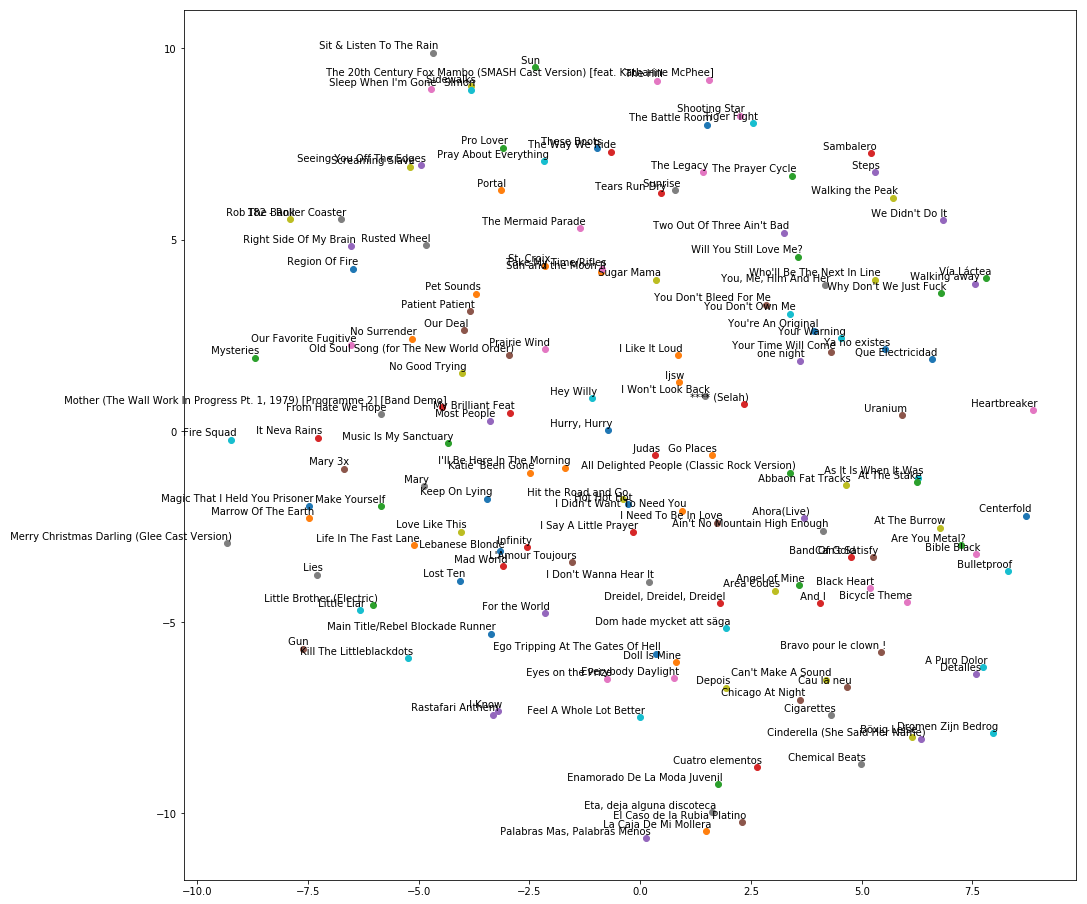

In [244]:
def label_format(label, condition=0):
    if condition == 1:
        return label.split("-", 1)[0]
    elif condition == 2:
        return label.split("-", 1)[1]
    else:
        return label


plt.figure(figsize=(16, 16)) 

for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i,0],X_tsne[i,1])
    plt.annotate(label_format(labels[i], 2),
                 xy=(X_tsne[i,0],X_tsne[i,1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [70]:
#nep on train 
k = 100
hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_playlist(train, k)
display((hits/tries, ndgc/tries, tries, fails))

(0.02769318614389037, 0.005495680122518508, 10508, 25)

In [68]:
#nep on test
k = 100
hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_playlist(test, k)
display((hits/tries, ndgc/tries, tries, fails))

(0.026325829835940482, 0.005214772497116482, 2621, 13)

## Appendix

In [113]:
#sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram
#min_count (int, optional) – Ignores all words with total frequency lower than this.
#window (int, optional) – Maximum distance between the current and predicted word within a sentence.
#sample (float, optional) – The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).

#hs ({0, 1}, optional) – If 1, hierarchical softmax will be used for model training.
#If 0, and negative is non-zero, negative sampling will be used.

#negative (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many 
#“noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.

#model = gensim.models.Word2Vec(documents, min_count=1, workers=16, sg=1, size = 300, hs=1, window = 5)
#model.train(documents,total_examples=len(documents),epochs=1)

#window_size window-size
#it number of epochs 
#sample sub-sampling parameter
#power-alpha negative sampling distribution parameter

#window_size=3
#it=20 #increasing this leads to returning words with wrong similarity
#sample=0.0001 
#power_alpha=-0.5

#other
#size_embedding=50
#neg_sample=5
#workers=10
#min_count=5 #cold start?

#window_size=7
#it=20 #increasing this leads to returning words with wrong similarity
#sample=0.001 
#power_alpha=0.025

#size_embedding=50
#neg_sample=5
#workers=10
#min_count=2 #cold start?


#model = gensim.models.Word2Vec(test, size=size_embedding, window=window_size,
#                 min_count=min_count, workers=workers, sg=1, iter=it,
#                 sample=sample, negative=neg_sample, alpha=power_alpha)

#model.train(test,total_examples=len(test), epochs=model.iter)